# for meanNN entorpy

In [240]:
import torch
import numpy as np
import cv2
# import scipy

from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import ica

from util import entropyLoss, getdata, infomaxICA

In [213]:
n_dist = 2
A = np.random.normal(0, 0.5,(n_dist,n_dist))
print('condition number:', np.linalg.cond(A))
X_list = []
for i in range(n_dist):
    scale = np.random.randint(1,15)
    print(scale)
    X_list.append(np.random.laplace(scale=scale, size=(1,16384)))
    
dist_c = np.concatenate(X_list)
Mixture = A@dist_c



condition number: 2.6806755474377475
12
3


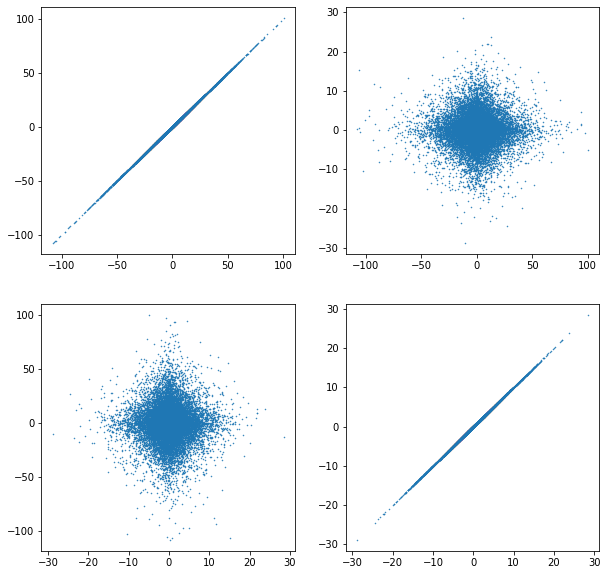

In [214]:
plt.figure(figsize=(10,10))

sub_shape = n_dist

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(dist_c[i, :], dist_c[j, :], '.', ms=1)

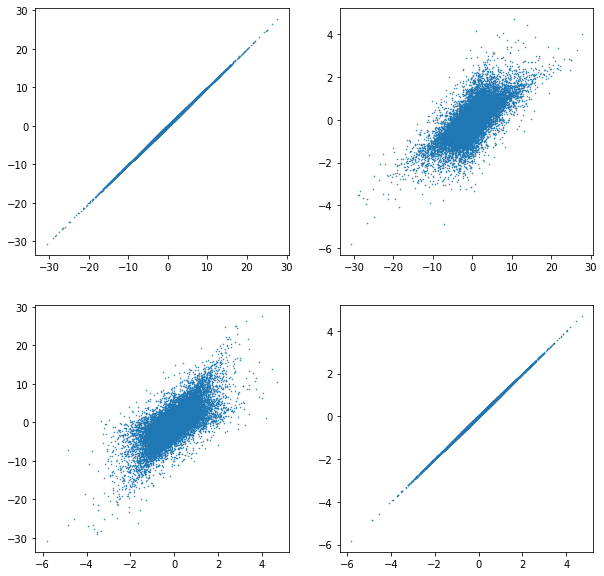

In [215]:
plt.figure(figsize=(10,10))
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(Mixture[i, :], Mixture[j, :], '.', ms=1)

In [216]:
# data whitening
x_white, white, dewhite = ica.pca_whiten(Mixture, n_dist)
IPT = x_white
IPT = torch.from_numpy(IPT).type(torch.float32)

In [217]:
# plt.plot(IPT[0,:], IPT[1,:], '.', ms=1)
# plt.title('mixture input after whitening')
# plt.axis('square')
# plt.grid()

In [218]:
device = torch.device('cuda:0')

In [219]:
model = infomaxICA(n_dist)

In [220]:
loss_tracker = []

In [224]:
dataset = getdata(IPT)
sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=128)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=0.01,
                             eps=10e-4,
#                              weight_decay = 1e-3,
                            )

num_epoch = 300
# scheduler = OneCycleLR(optimizer, 0.01, steps_per_epoch=len(loader), epochs=num_epoch)

# np.linalg.inv(model.W2.weight.data)

In [225]:
model = model.to(device)
IPT = IPT.to(device)

In [226]:
# %matplotlib notebook
# fig = plt.figure(figsize=(12,4))
# ax = fig.add_subplot(131)
# ax1 = fig.add_subplot(132)
# ax2 = fig.add_subplot(133)

trace = []

for epoch in range(num_epoch):
    for _, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt = model.forward(ipt)
        loss = entropyLoss(opt.T, device=device)
#         loss = entropyLoss(opt.permute(1,0))
#         optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss = loss.cpu()
    loss_tracker.append(loss.detach().numpy())
#     if loss.detach().numpy() < 1.5: 
#         break
#     if epoch % 3 == 0:
#         ax.clear()
#         ax.plot(loss_tracker)
#         fig.canvas.draw()
        
#         with torch.no_grad():
#             data = model.forward(IPT.T).cpu().detach().numpy()
#         ax1.clear()
#         ax1.plot(data[:, 0], data[:, 1], '.', ms=0.5)
#         fig.canvas.draw()
        
#         data2 = (model.W2.weight.data@IPT).cpu().detach().numpy()
# #         trace.append(data[300,:])
# #         trace.append(data2[:,102])
#         ax2.clear()
# #         ax2.plot(np.array(trace)[:, 0], np.array(trace)[:, 1])
#         ax2.plot(data2.T[:, 0], data2.T[:, 1], '.', ms=0.5)
#         ax2.set_aspect('equal')
#         fig.canvas.draw()
    
    print(epoch, loss.detach().numpy())
#     scheduler.step()

0 1.082037
1 1.0747906
2 1.0810304
3 1.073511
4 1.1068156
5 1.0973097
6 1.0970726
7 1.0961293
8 1.1081964
9 1.1121564
10 1.0742202
11 1.1012853
12 1.0876417
13 1.088577
14 1.0937041
15 1.0853084
16 1.08997
17 1.1074718
18 1.1023148
19 1.1011376
20 1.0928352
21 1.1162289
22 1.0939463
23 1.0580631
24 1.0696872
25 1.094212
26 1.0890931
27 1.0785189
28 1.0687568
29 1.0846738
30 1.0729731
31 1.0834031
32 1.1110348
33 1.1022235
34 1.0582706
35 1.1151894
36 1.1146507
37 1.0984752
38 1.140593
39 1.0916791
40 1.0654756
41 1.1118971
42 1.0856873
43 1.077781
44 1.1275371
45 1.1215813
46 1.099031
47 1.1181035
48 1.0787914
49 1.1053377
50 1.0932041
51 1.1010551
52 1.08008
53 1.1524076
54 1.0997413
55 1.0833083
56 1.0843015
57 1.095505
58 1.10354
59 1.0928099
60 1.1286515
61 1.081349
62 1.0792319
63 1.0710756
64 1.0880997
65 1.0982679
66 1.0887101
67 1.1089487
68 1.1021549
69 1.106322
70 1.0732036
71 1.08341
72 1.1154085
73 1.0979327
74 1.0924726
75 1.117196
76 1.0995786
77 1.0953418
78 1.1187189
79

KeyboardInterrupt: 

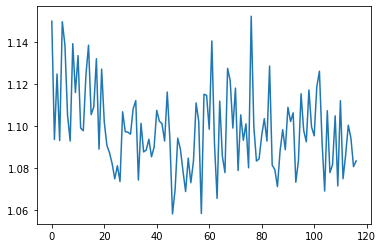

In [227]:
%matplotlib inline
plt.plot(loss_tracker)

In [228]:
model.cpu()
IPT = IPT.cpu()

In [229]:
with torch.no_grad():
    data = model.forward(IPT.T).detach().numpy() # B.detach().numpy()#

data_mnn = model.W2.weight.data@IPT
# data_mnn = data_mnn/(data_mnn.std(axis=1).reshape((-1,1)))
print('the condition number of weight:', np.linalg.cond(model.W2.weight.data))
print('mixture matrix:', A, sep='\n')
print('inverse of matrix in model:', np.linalg.inv(model.W2.weight.data.T), sep='\n')

the condition number of weight: 1.101948
mixture matrix:
[[ 0.26930331 -0.13310459]
 [ 0.03225784 -0.15686099]]
inverse of matrix in model:
[[ 0.00290636 -0.0234866 ]
 [ 0.02132241  0.00257433]]


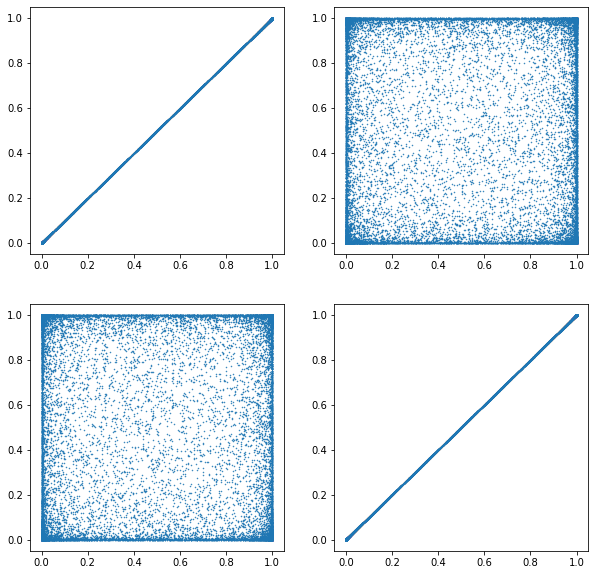

In [230]:
plt.figure(figsize=(10,10))

sub_shape = n_dist

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data[:, i], data[:, j], '.', ms=1)

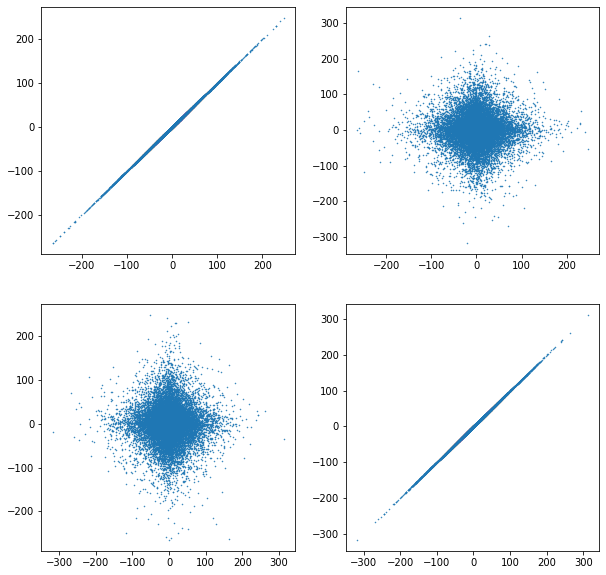

In [231]:
plt.figure(figsize=(10,10))

sub_shape = n_dist

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data_mnn.T[:, i], data_mnn.T[:, j], '.', ms=1)

In [199]:
# %matplotlib inline
# plt.figure(figsize=(4,10))

# plt.subplot(3,1,1)
# plt.plot(IPT[0,:], IPT[1,:], '.', ms=1)
# plt.title('mixture input after whitening')
# plt.axis('square')
# plt.grid()

# # plot without sigmoid
# plt.subplot(3,1,2)
# plt.plot(data_mnn.T[:,0], data_mnn.T[:,1], '.', ms=0.1)
# plt.title('output without sigmoid')
# # plt.xlim([-5, 5])
# # plt.ylim([-5, 5])
# plt.axis('square')
# plt.grid()

# # plot of the original laplace
# plt.subplot(3,1,3)
# plt.plot(ls1, ls2, '.', ms=1)
# plt.title('ground truth')
# plt.axis('square')
# plt.grid()

# fastIA

In [202]:
from sklearn.decomposition import FastICA

In [203]:
transformer = FastICA()
data_fastica = transformer.fit_transform(Mixture.T)

In [204]:
print('the condition number of mixing matrix is:', np.linalg.cond(transformer.components_))

the condition number of mixing matrix is: 15.387392943399622


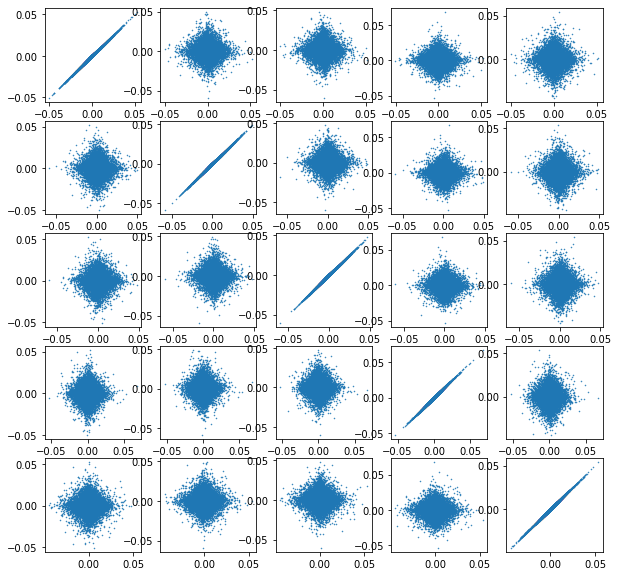

In [205]:
plt.figure(figsize=(10,10))

sub_shape = n_dist

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data_fastica[:, i], data_fastica[:, j], '.', ms=1)

In [206]:
# plt.figure(figsize=(4,12))



# plt.subplot(3,1,1)
# plt.plot(Mixture[0,:], Mixture[1,:], '.', ms=1)
# plt.title('mixture input')
# # plt.axis('square')
# plt.grid()

# # plot without sigmoid
# plt.subplot(3,1,2)
# plt.plot(data_fastica[:,0], data_fastica[:,1], '.', ms=0.1)
# plt.title('output')
# plt.axis('square')
# plt.grid()

# plt.subplot(3,1,3)
# plt.plot(ls1, ls2, '.', ms=1)
# plt.title('mixture input')
# plt.axis('square')
# plt.grid()

In [207]:
# np.cov(data_fastica.T)

# infomax

In [208]:
A0, data_infomax, W = ica.ica1(Mixture, n_dist, verbose=True)

Whitening data...
x_white shape: 5, 16384
Done.
Running INFOMAX-ICA ...
Beginning ICA training...
Step 59: Lrate 7.7e-06,Wchange 8.5e-07,Angle 123.07
Done.


In [209]:
print('the condition number of mixing matrix is:', np.linalg.cond(W))

the condition number of mixing matrix is: 1.0105990853248081


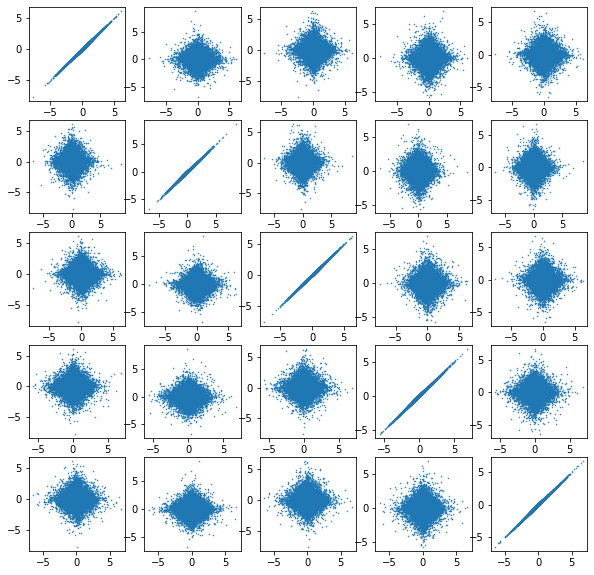

In [210]:
plt.figure(figsize=(10,10))

sub_shape = n_dist

for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data_infomax.T[:, i], data_infomax.T[:, j], '.', ms=1)

In [60]:
# plt.figure(figsize=(4,12))

# plt.subplot(3,1,1)
# plt.plot(Mixture[0,:], Mixture[1,:], '.', ms=1)
# plt.title('mixture input')
# # plt.axis('square')
# plt.grid()

# # plot without sigmoid
# plt.subplot(3,1,2)
# plt.plot(data_infomax.T[:,0], data_infomax.T[:,1], '.', ms=0.1)
# plt.title('output')
# plt.axis('square')
# plt.grid()

# plt.subplot(3,1,3)
# plt.plot(ls1, ls2, '.', ms=1)
# plt.title('mixture input')
# plt.axis('square')
# plt.grid()

In [62]:
# plt.figure(figsize=(9,3))

# plt.subplot(1,3,1)
# plt.plot(data_mnn.T[:,0], data_mnn.T[:,1], '.', ms=1)
# plt.title('my model')
# plt.axis('square')
# plt.grid()

# # plot without sigmoid
# plt.subplot(1,3,2)
# plt.plot(data_fastica[:,0], data_fastica[:,1], '.', ms=1)
# plt.title('fastICA')
# plt.axis('square')
# plt.grid()

# plt.subplot(1,3,3)
# plt.plot(data_infomax.T[:,0], data_infomax.T[:,1], '.', ms=1)
# plt.title('infomax')
# plt.axis('square')
# plt.grid()